In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Import necessary scikit-learn modules and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, auc, accuracy_score, precision_score, recall_score,
                             matthews_corrcoef, f1_score, average_precision_score,
                             cohen_kappa_score)
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the dataset into a Pandas DataFrame
credit_card_data = pd.read_csv('Downloads/creditcard_2023.csv')

In [3]:
# Assuming 'Class' is the target and the rest are features
X = credit_card_data.drop(columns='Class', axis=1)
Y = credit_card_data['Class']

In [4]:
# Split the data into training and testing sets with stratification (80-20 split)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)

In [5]:
# Initialize the Perceptron model with max_iter set to 10000
model = Perceptron(max_iter=10000)

In [6]:
# Start timer to measure training time
start_time = time.time()

# Fit the model on the training data
model.fit(X_train, Y_train)

# End timer and record elapsed time
end_time = time.time()
training_time = end_time - start_time
print(f"Time taken to fit the model: {training_time:.2f} seconds")

Time taken to fit the model: 1.90 seconds


In [7]:
# Evaluate on training data
Y_train_pred = model.predict(X_train)
training_accuracy = accuracy_score(Y_train, Y_train_pred)
print('Training Accuracy:', training_accuracy)

Training Accuracy: 0.6861030019520602


In [8]:
# Evaluate on test data
Y_pred = model.predict(X_test)
test_accuracy = accuracy_score(Y_test, Y_pred)
print('Test Accuracy:', test_accuracy)

Test Accuracy: 0.6858502013611664


In [9]:
# Print classification report
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.81      0.72     56863
           1       0.75      0.56      0.64     56863

    accuracy                           0.69    113726
   macro avg       0.70      0.69      0.68    113726
weighted avg       0.70      0.69      0.68    113726



In [10]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[46190 10673]
 [25054 31809]]


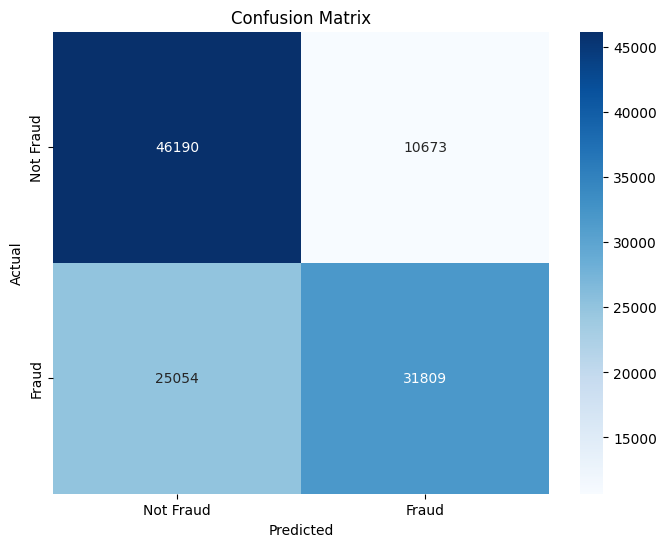

In [11]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [12]:
# Extract individual values from the confusion matrix: TN, FP, FN, TP
TN, FP, FN, TP = conf_matrix.ravel()

In [13]:
# Calculate basic derived metrics
sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0  # Recall: ability to detect fraud
specificity = TN / (TN + FP) if (TN + FP) != 0 else 0  # Ability to correctly identify legit transactions
precision = TP / (TP + FP) if (TP + FP) != 0 else 0      # Proportion of predicted frauds that are actual frauds
mcc = matthews_corrcoef(Y_test, Y_pred)                  # Matthews Correlation Coefficient
BCR = (sensitivity + specificity) / 2                    # Balanced Classification Rate

In [14]:
# Calculate additional metrics
f1 = f1_score(Y_test, Y_pred)                            # F1 Score: harmonic mean of precision and recall
# Use decision_function since Perceptron does not support predict_proba
decision_scores = model.decision_function(X_test)
avg_precision = average_precision_score(Y_test, decision_scores)  # Average Precision (AUC-PR)
kappa = cohen_kappa_score(Y_test, Y_pred)                # Cohen's Kappa

In [15]:
print("\nDerived Metrics:")
print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)
print("Precision:", precision)
print("F1 Score:", f1)
print("MCC:", mcc)
print("BCR:", BCR)
print("Average Precision (AUC-PR):", avg_precision)
print("Cohen's Kappa:", kappa)


Derived Metrics:
Sensitivity (Recall): 0.5593971475300283
Specificity: 0.8123032551923043
Precision: 0.7487641824772845
F1 Score: 0.6403744526649554
MCC: 0.3841901052435365
BCR: 0.6858502013611663
Average Precision (AUC-PR): 0.8071494409807118
Cohen's Kappa: 0.3717004027223326


In [16]:
# Compute ROC AUC using the decision function scores
roc_auc = roc_auc_score(Y_test, decision_scores)
print(f"\nROC AUC Score: {roc_auc:.4f}")


ROC AUC Score: 0.7907


In [17]:
# Compute ROC curve data points
fpr, tpr, thresholds = roc_curve(Y_test, decision_scores)
roc_auc_val = auc(fpr, tpr)

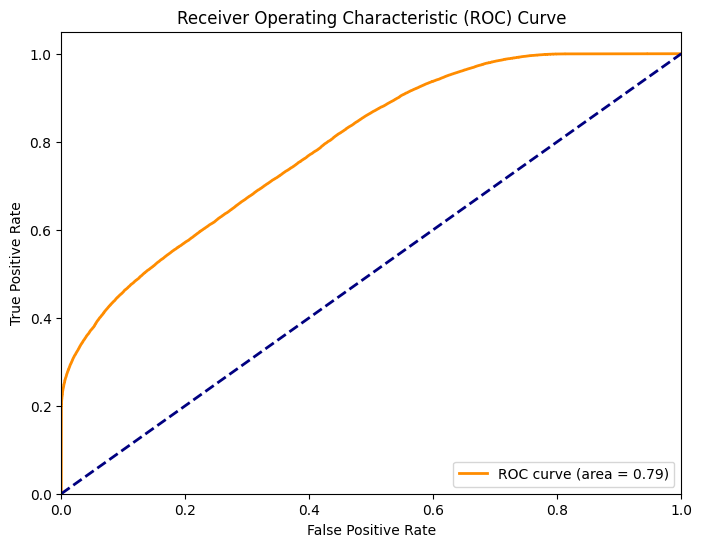

In [18]:
# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [19]:
# Use the ROC curve for practical threshold selection:
# Calculate Youden's J statistic (tpr - fpr) and choose the threshold with maximum J.
J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold = thresholds[optimal_idx]
print("Optimal Threshold (Youden's Index):", optimal_threshold)

Optimal Threshold (Youden's Index): -11963682823.340622


In [20]:
# Recalculate predictions using the optimal threshold
Y_pred_optimal = (decision_scores >= optimal_threshold).astype(int)
opt_conf_matrix = confusion_matrix(Y_test, Y_pred_optimal)
opt_accuracy = accuracy_score(Y_test, Y_pred_optimal)
print("\nMetrics with Optimal Threshold:")
print("Optimal Test Accuracy:", opt_accuracy)
print("Optimal Confusion Matrix:")
print(opt_conf_matrix)


Metrics with Optimal Threshold:
Optimal Test Accuracy: 0.6864745089073738
Optimal Confusion Matrix:
[[40367 16496]
 [19160 37703]]


/var/folders/mg/xpmfk2gj16g9f0d644jfl6gw0000gn/T/ipykernel_20390/3038077064.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


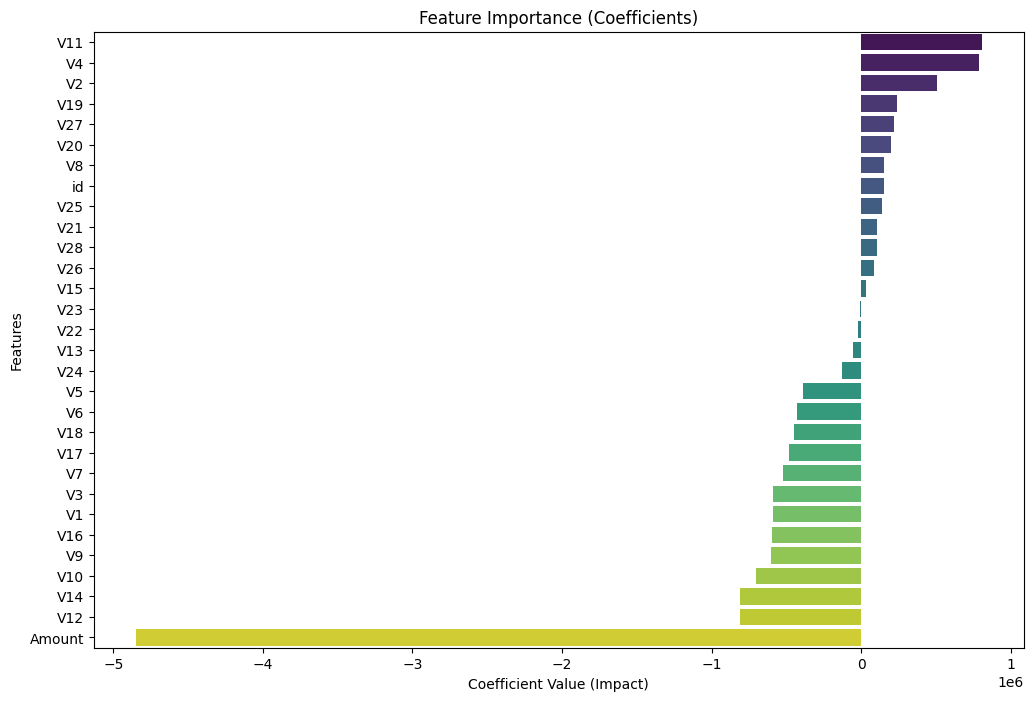

In [21]:
# Extract and visualize feature importance (applicable since Perceptron has coefficients)
feature_importance = model.coef_[0]
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance (Coefficients)')
plt.xlabel('Coefficient Value (Impact)')
plt.ylabel('Features')
plt.show()

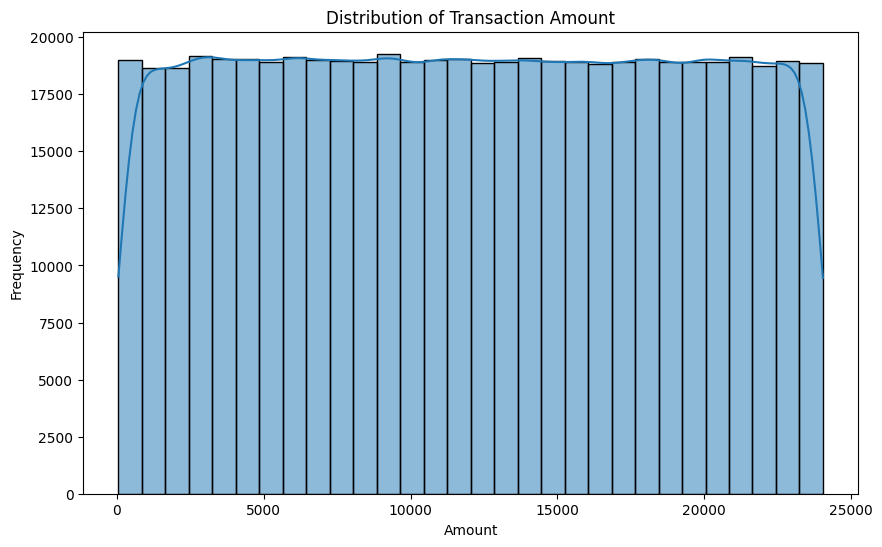

In [22]:
# Distribution of Transaction Amount
plt.figure(figsize=(10, 6))
sns.histplot(credit_card_data['Amount'], kde=True, bins=30)
plt.title('Distribution of Transaction Amount')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

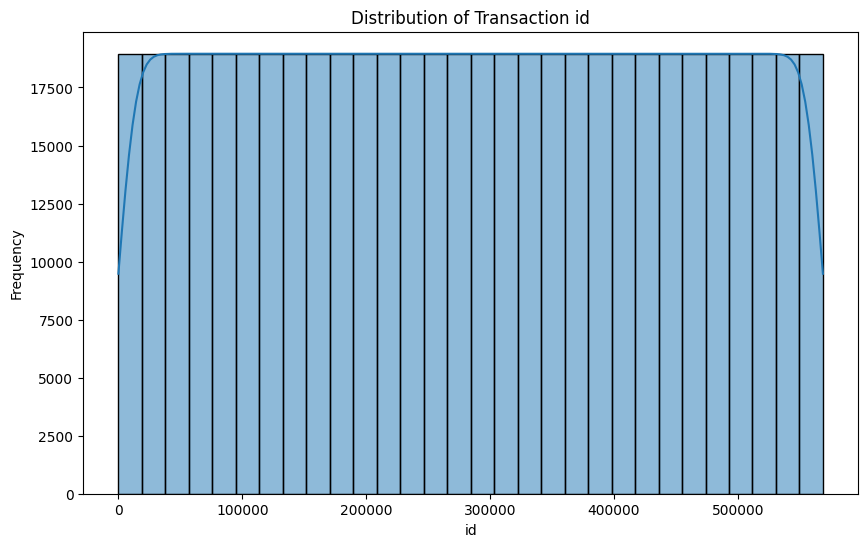

In [23]:
# Distribution of Transaction ID (after handling infinite values)
credit_card_data['id'] = credit_card_data['id'].replace([np.inf, -np.inf], np.nan)
plt.figure(figsize=(10, 6))
sns.histplot(credit_card_data['id'], kde=True, bins=30)
plt.title('Distribution of Transaction id')
plt.xlabel('id')
plt.ylabel('Frequency')
plt.show()

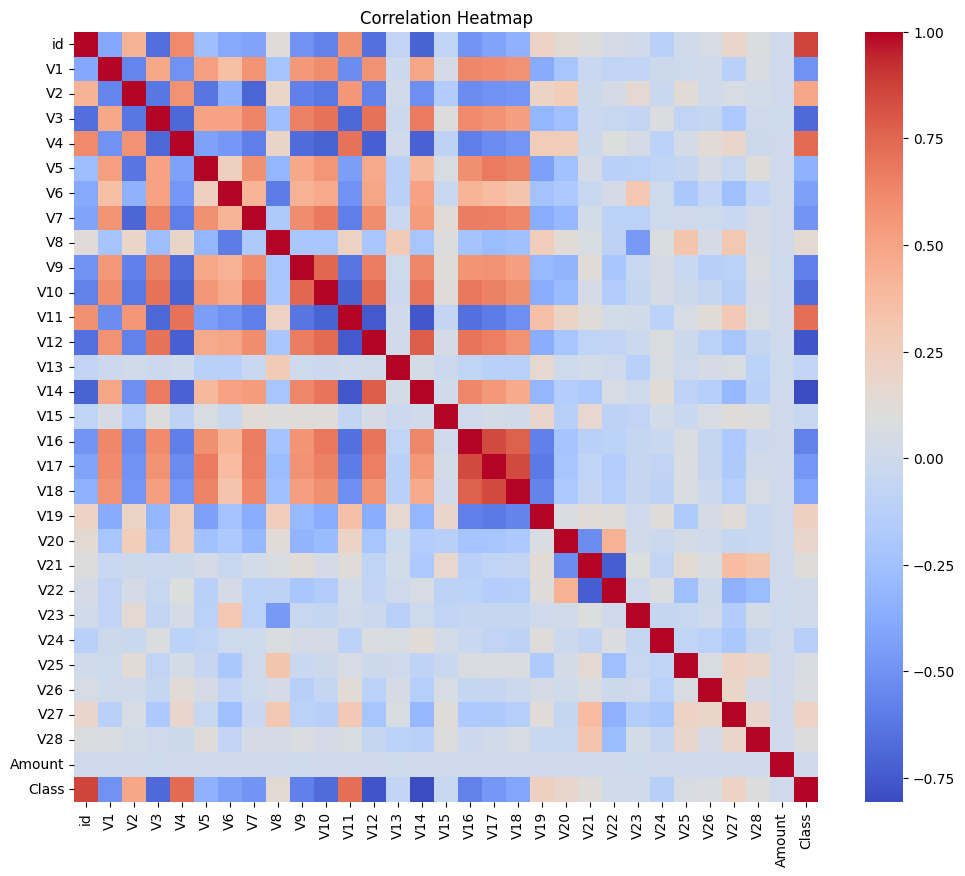

In [24]:
# Correlation Heatmap for the entire dataset
plt.figure(figsize=(12, 10))
corr = credit_card_data.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [25]:
# Create a dictionary to store evaluation metrics for this model.
results = {}
results["Perceptron"] = {
    "Training Accuracy": training_accuracy,
    "Test Accuracy": test_accuracy,
    "Optimal Test Accuracy": opt_accuracy,
    "Sensitivity": sensitivity,
    "Specificity": specificity,
    "Precision": precision,
    "F1 Score": f1,
    "MCC": mcc,
    "BCR": BCR,
    "ROC AUC": roc_auc,
    "Average Precision": avg_precision,
    "Cohen's Kappa": kappa,
    "Training Time (s)": training_time,
    "Optimal Threshold": optimal_threshold
}

In [26]:
# If you have multiple models, repeat the above block for each and add entries accordingly.
results_df = pd.DataFrame(results).T  # Transpose so that each row represents a model
print("\nComparison Table of Evaluation Metrics:")
print(results_df)


Comparison Table of Evaluation Metrics:
            Training Accuracy  Test Accuracy  Optimal Test Accuracy  \
Perceptron           0.686103        0.68585               0.686475   

            Sensitivity  Specificity  Precision  F1 Score      MCC      BCR  \
Perceptron     0.559397     0.812303   0.748764  0.640374  0.38419  0.68585   

             ROC AUC  Average Precision  Cohen's Kappa  Training Time (s)  \
Perceptron  0.790711           0.807149         0.3717           1.897615   

            Optimal Threshold  
Perceptron      -1.196368e+10  
